# WeatherPy
----

### WeatherPy Evaluation
   >* TREND OBSERVATION 1: Per temperature data, the northern hemisphere is in its summer season. Summer is defined by warmer temperatures created by the 23.5° tilt of the earth and which pole is nearer the sun. The seasons shift as the earth rotates around the sun. The more direct the sunlight (nearer the pole to the sun), the warmer the temperature. The northern hemisphere (Latitudes 0 through 90) reflect more data points at higher temperatures than the southern hemisphere lending to the assumption that it is summer.
   
   >* TREND OBSERVATION 2: Humidity data collected on July 13, 2019, displays a nice visualization of the Coriolis Effect. The area between the Tropic of Cancer at 30° North and Tropic of Capricorn at 30° South is generally referred to as the Tropics. The Equator is half way between at 0° latitude. The Tropics are where the sun shines directly down onto, not at an angle to, the earth's surface. This direct sunlight causes significant evaporation of the ground and ocean water and leads to higher humidity levels. The Coriolis Effect creates convection cells and moves warm moist air up into the atmosphere and toward the respective 30° latitude. As the air in the Tropics rises and cools, it releases moisture as precipitation (cyclically) and the air maintains fairly high relative humidity. As the now cool dry air descends near the 30° latitude lines of each hemisphere, it warms and expands resulting in a somewhat 'dehydrating' effect. In the humidity plot, observe that nearer the 30° latitudes are where the lowest humidities are recorded. Also notice the higher levels of humidity as you approach the midpoint. With higher temperatures in the northern hemisphere due to summer, it is natural to see slightly more humidity. The Coriolis Effect results in many of the worlds deserts and being located near the 30th latitudes.
   
   >* TREND OBSERVATION 3: The reported data for cloudiness intimates that although the data is collected in units of percentage, many of the weather stations are reporting the percentage equivalent to the meteorological standard unit of an okta (a scale of 9 units ranging from 0 to 8). This results in heavy clustering of data points along certain percentage lines. 
   
   >* TREND OBSERVATION 4: Fewer data points return the further south you go. This is because there is less habitable land mass and more ocean than the same latitudes in the northern hemisphere. Randomization of data points hits fewer 'near cities' in the range of -90 to 0. Additionally, the southernmost city in the world is Ushuaia, Argentina at approximately 55.5° South. There are only about 100 habitations below the 53rd parallel, 90 of which are Antarctic seasonal or permanent stations. Of these, not all have weather stations, so while the random generator could surely return data below 55° South, it is low probability and certainly will not be densely marked
   
**Requires additional location data and testing. Results will change as data is re-run.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime
from citipy import citipy
from api_keys import api_key

## Generate Cities List

In [2]:
# Set ranges of potential latitudes and longitudes
lat_set = (-90, 90)
long_set = (-180, 180)

# create empty lists for coordinates, cities/searchable city names, and country codes
lat_longs = []
cities = []
search_cities = [] # replaces each :space: in city name with :+: symbol allowing for usage in API web address
countries = []

# Create a set of random coordinates (min 500 usable results)
lats = np.random.uniform(low = -90.0000, high = 90.0000, size = 2000)
longs = np.random.uniform(low = -180.0000, high = 180.0000, size = 2000)
lat_longs = zip(lats, longs)

# Identify nearest city for each set of coordinates, add only if not already in list
for lat_long in lat_longs:
    city_name = citipy.nearest_city(lat_long[0], lat_long[1]).city_name
    country_code = citipy.nearest_city(lat_long[0], lat_long[1]).country_code
    if city_name not in cities:
        cities.append(city_name)
        countries.append(country_code)

# Replace spaces in multi-word city names with '+' so url doesn't 'break' at space in API address
for city in cities:
        readable_city = city.replace(' ', '+') # may alternately use '+' OR '%20' - both work for this API!
        search_cities.append(readable_city)

# generate searchable item list for API
search_list = list(zip(search_cities, countries))

print(f'{len(lats)} coordinates collected, with {len(search_cities)} cities generated via citypy.nearest_city.')

2000 coordinates collected, with 775 cities generated via citypy.nearest_city.


## Perform API Calls

In [3]:
# Base API url for calls
url = 'http://api.openweathermap.org/data/2.5/weather?appid='
units = 'imperial'

# create empty lists for data collection
city_cap = [] # duplicates info from cities variable, but in a nicer format for df (proper capitalization)
country_cap = [] # duplicates info from countries variable, but in a nicer format for df (proper capitalization)
lat = []
temp = []
humidity = []
cloudiness = []
wind_speed = []
dates = []
failure_count = []


print('''
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
=                                         Processing Records                                          =
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

''')

for call_count in range(len(search_list)):
    try:
        city = search_list[call_count][0]
        country = search_list[call_count][1]

        city_url = (url + api_key + '&units='+ units + '&q=' + city + ',' + country)
        weather_data = requests.get(city_url).json() 

        if weather_data['cod'] == '404':
            call_count += 1
            failure_count.append(f'City Call {call_count}')
            print(f'City Call {call_count}:  {str.title(city)}, {str.upper(country)} ***** FAILED: City Not Found *****')
        elif weather_data['main']['humidity'] >= 101:
            call_count += 1
            failure_count.append(f'City Call {call_count}')
            print(f'City Call {call_count}: {city_log}, {country_log} ***** DATA OUT OF BOUNDS: City Not Included *****')
        else:
            city_cap.append(weather_data['name'])
            city_log = weather_data['name']
            country_cap.append(weather_data['sys']['country'])
            country_log = weather_data['sys']['country']
            lat.append(weather_data['coord']['lat'])
            temp.append(weather_data['main']['temp_max'])
            humidity.append(weather_data['main']['humidity'])
            cloudiness.append(weather_data['clouds']['all'])
            wind_speed.append(weather_data['wind']['speed'])
            timestamp = datetime.fromtimestamp(weather_data['dt']).strftime('%m/%d/%Y - %I:%M %p')
            dates.append(timestamp)

            call = (f'City Call {call_count + 1}:  {city_log}, {country_log}')
            print(call)

        call_count += 1
        time.sleep(.050)
    except:
        print('= + = + = + = + = + = +     ERROR     + = + = + = + = + = + =')
    pass  


print('''
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
=                                      Data Collection Complete!                                      =
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
''')

# quick review/validation of lists 
print(f'''
{len(search_list)} random, unique cities generated.

{len(failure_count)} FAILURES TO CALL:
-------------------------------------------------------------------------------------------------------
{failure_count}


Complete data will have {len(search_list) - len(failure_count)} items.

Item Count:
{len(city_cap)} Cities
{len(country_cap)} Countries
{len(lat)} Latitudes
{len(temp)} Temperatures
{len(humidity)} Humidity Percentages
{len(cloudiness)} Cloudiness Percentages
{len(wind_speed)} Wind Speeds
{len(dates)} Dates
''')


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
=                                         Processing Records                                          =
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


City Call 1:  Laurel, US
City Call 2:  Port Alfred, ZA
City Call 3:  Grand Gaube, MU
City Call 4:  Ushuaia, AR
City Call 5:  Puerto Ayora, EC
City Call 6:  Bredasdorp, ZA
City Call 7:  Bethel, US
City Call 8:  Busselton, AU
City Call 9:  Carauari, BR
City Call 10:  Vardo, NO
City Call 11:  Saint-Joseph, RE
City Call 12:  Palabuhanratu, ID ***** FAILED: City Not Found *****
City Call 13:  Babanusah, SD ***** FAILED: City Not Found *****
City Call 14:  Rikitea, PF
City Call 15:  Ulladulla, AU
City Call 16:  Paris, US
City Call 17:  Tecoanapa, MX
City Call 18:  San Patricio, MX
City Call 19:  Khatanga, RU
City Call 20:  Daru, PG
City Call 21:  Presidencia Roque Saenz Pena, AR
Cit

City Call 228:  Moose Factory, CA
City Call 229:  Lompoc, US
City Call 230:  Wuwei, CN
City Call 231:  Khon Buri, TH
City Call 232:  Bam, IR
City Call 233:  Meulaboh, ID
City Call 234:  Chicama, PE
City Call 235:  Mantua, CU
City Call 236:  Karamea, NZ ***** FAILED: City Not Found *****
City Call 237:  Changde, CN
City Call 238:  Kudahuvadhoo, MV
City Call 239:  Avera, PF ***** FAILED: City Not Found *****
City Call 240:  Benicarlo, ES
City Call 241:  Hohhot, CN
City Call 242:  Ilo, PE
City Call 243:  Ondorhaan, MN ***** FAILED: City Not Found *****
City Call 244:  Sola, VU
City Call 245:  Imbituba, BR
City Call 246:  Saint-Philippe, RE
City Call 247:  Chokurdakh, RU
City Call 248:  Acapulco, MX
City Call 249:  Kodinar, IN
City Call 250:  Beloha, MG
City Call 251:  Saint George, BM
City Call 252:  Alberton, CA
City Call 253:  Nikolskoye, RU
City Call 254:  Nalut, LY
City Call 255:  Westport, IE
City Call 256:  Clyde River, CA
City Call 257:  Kaya, BF
City Call 258:  Jidong, CN
City Cal

City Call 478:  Aksarayskiy, RU
City Call 479:  Mys+Shmidta, RU ***** FAILED: City Not Found *****
City Call 480:  Cavarzere, IT
City Call 481:  Presidente Medici, BR
City Call 482:  Rosarito, MX
City Call 483:  Bereda, SO ***** FAILED: City Not Found *****
City Call 484:  Nizhnyaya Poyma, RU
City Call 485:  Mednogorskiy, RU
City Call 486:  Nuuk, GL
City Call 487:  George, ZA
City Call 488:  Khed Brahma, IN
City Call 489:  Tobermory, GB ***** FAILED: City Not Found *****
City Call 490:  Sao Felix do Xingu, BR
City Call 491:  Nenjiang, CN
City Call 492:  Najran, SA
City Call 493:  Deder, ET
City Call 494:  Nalhati, IN
City Call 495:  Makakilo City, US
City Call 496:  Taltal, CL
City Call 497:  Ambilobe, MG
City Call 498:  Kaeo, NZ
City Call 499:  Eyl, SO
City Call 500:  Nyurba, RU
City Call 501:  Tabiauea, KI ***** FAILED: City Not Found *****
City Call 502:  Kuche, CN ***** FAILED: City Not Found *****
City Call 503:  Yorkton, CA
City Call 504:  Leningradskiy, RU
City Call 505:  Kysyl-

City Call 721:  Klaksvik, FO
City Call 722:  Pontes e Lacerda, BR
City Call 723:  Asfi, MA ***** FAILED: City Not Found *****
City Call 724:  Jefferson City, US
City Call 725:  Egra, IN
City Call 726:  Jiuquan, CN
City Call 727:  Chopinzinho, BR
City Call 728: Chopinzinho, BR ***** DATA OUT OF BOUNDS: City Not Included *****
City Call 729:  Kailua, US
City Call 730:  Vanimo, PG
City Call 731:  Leo, BF
City Call 732:  Abu+Jubayhah, SD ***** FAILED: City Not Found *****
City Call 733:  Buchanan, LR
City Call 734:  Mandalgovi, MN
City Call 735:  Williston, US
City Call 736:  Shakhtinsk, KZ
City Call 737:  Mayor Pablo Lagerenza, PY
City Call 738:  Liverpool, CA
City Call 739:  Kloulklubed, PW
City Call 740:  Brookings, US
City Call 741:  Portland, AU
City Call 742:  Odessa, US
City Call 743:  Matadi, CD
City Call 744:  Young, UY
City Call 745:  Parana, AR
City Call 746:  Dodoma, TZ
City Call 747:  Walvis Bay, NA
City Call 748:  Baykit, RU
City Call 749:  Tabou, CI
City Call 750:  Zabid, YE

## Convert Raw Data to DataFrame

In [4]:
city_weather_df = (pd.DataFrame({'City': city_cap, 
                                 'Country': country_cap, 
                                 'Latitude': lat, 
                                 'Temperature (F)': temp, 
                                 'Humidity (%)': humidity, 
                                 'Cloudiness (%)': cloudiness, 
                                 'Wind Speed (mph)': wind_speed, 
                                 'Date - Time Reported': dates}))

# variable for naming convention of output files and DATE in plot titles: represents date the information is called
called_on = datetime.now().strftime('%B %d, %Y')

city_weather_df.head()

,City,Country,Latitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),Date - Time Reported
0,Laurel,US,31.69,75.20,94,90,9.17,07/13/2019 - 09:31 AM
1,Port Alfred,ZA,-33.59,64.99,81,0,1.99,07/13/2019 - 09:26 AM
2,Grand Gaube,MU,-20.01,73.40,53,75,10.29,07/13/2019 - 09:26 AM
3,Ushuaia,AR,-54.81,41.00,86,75,3.36,07/13/2019 - 09:20 AM
4,Puerto Ayora,EC,-0.74,69.80,83,20,2.24,07/13/2019 - 09:25 AM


In [5]:
city_weather_df.count()
city_weather_df.to_csv((f'OUTPUT - Weather Data {called_on}.csv'), index=False)

## Plotting the Data

### Temperature Plot

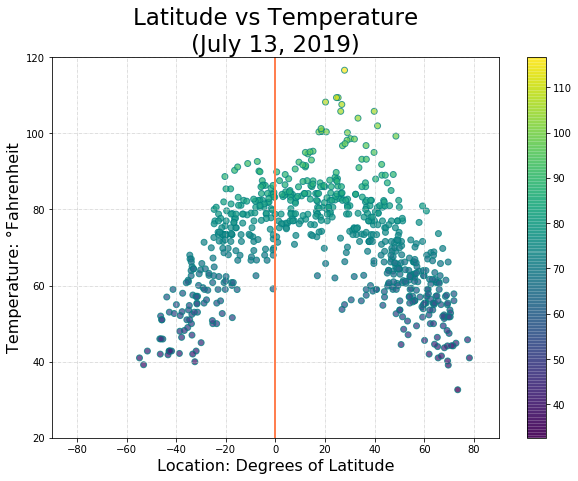

In [6]:
plt.figure(figsize = (10, 7))

plt.scatter(city_weather_df['Latitude'], city_weather_df['Temperature (F)'], 
            marker = 'o', 
            c = city_weather_df['Temperature (F)'],
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Latitude vs Temperature\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.xlabel('Location: Degrees of Latitude', fontsize = 16)
plt.xlim (-90, 90)

# Label and limits for y-axis.
plt.ylabel('Temperature: °Fahrenheit', fontsize = 16)
plt.ylim (20, 120)

# Add light grid with axis line for equator
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(linewidth = 2, color = 'coral')

# Show colorbar
plt.colorbar()

plt.savefig((f'PLOT - Temperature {called_on}.png'))
plt.show()

### Humidity Plot

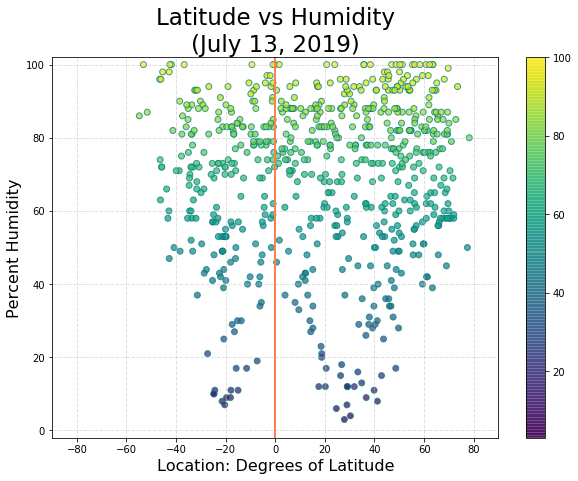

In [7]:
plt.figure(figsize = (10, 7))

plt.scatter(city_weather_df['Latitude'], city_weather_df['Humidity (%)'], 
            marker = 'o', 
            c = city_weather_df['Humidity (%)'],
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Latitude vs Humidity\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.xlabel('Location: Degrees of Latitude', fontsize = 16)
plt.xlim (-90, 90)

# Label and limits for y-axis.
plt.ylabel('Percent Humidity', fontsize = 16)
plt.ylim (-2, 102)

# Add light grid with axis line for equator
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(linewidth = 2, color = 'coral')

# Show colorbar
plt.colorbar()
plt.savefig((f'PLOT - Humidity {called_on}.png'))

plt.show()

### Cloudiness Plot

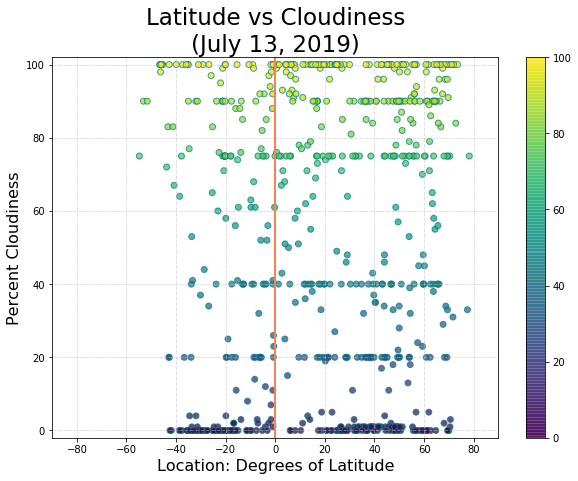

In [8]:
plt.figure(figsize = (10, 7))

plt.scatter(city_weather_df['Latitude'], city_weather_df['Cloudiness (%)'], 
            marker = 'o', 
            c = city_weather_df['Cloudiness (%)'],
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Latitude vs Cloudiness\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.xlabel('Location: Degrees of Latitude', fontsize = 16)
plt.xlim (-90, 90)

# Label and limits for y-axis.
plt.ylabel('Percent Cloudiness', fontsize = 16)
plt.ylim (-2, 102)

# Add light grid with axis line for equator
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(linewidth = 2, color = 'coral')

# Show colorbar
plt.colorbar()
plt.savefig((f'PLOT - Cloudiness {called_on}.png'))

plt.show()

### Wind Speed Plot

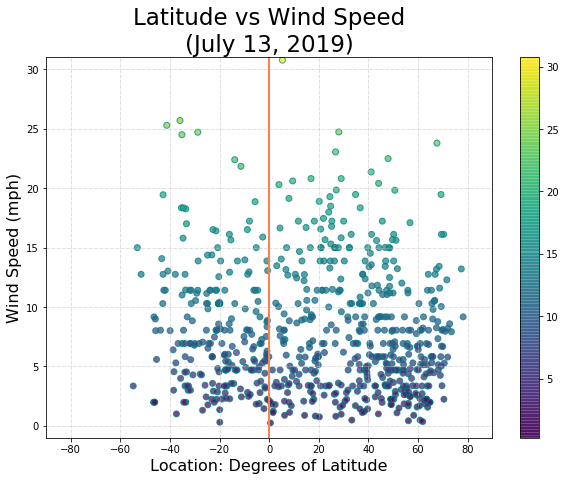

In [9]:
plt.figure(figsize = (10, 7))

plt.scatter(city_weather_df['Latitude'], city_weather_df['Wind Speed (mph)'], 
            marker = 'o', 
            c = city_weather_df['Wind Speed (mph)'],            
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Latitude vs Wind Speed\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.xlabel('Location: Degrees of Latitude', fontsize = 16)
plt.xlim (-90, 90)

# Label and limits for y-axis.
plt.ylabel('Wind Speed (mph)', fontsize = 16)
plt.ylim (-1, 31)

# Add light grid with axis line for equator
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(linewidth = 2, color = 'coral')

# Show colorbar
plt.colorbar()
plt.savefig((f'PLOT - Wind Speed {called_on}.png'))

plt.show()

## ADDITIONAL PLOTTING: Setting y-axis to Latitude
  * While not the standard convention of plotting because I am flipping the traditional static, x-axis and variable, y-axis, I thought it would be interesting to view the data in a traditional, latitudinal, North to South display.
  * This would not be appropriate for actual *scientific* analysis, papers, or presentations, but may be helpful in a simple graphical representation for the lay-person since the lines of latitude go 'up and down' in a similar manner to the standard world map!

### Temperature Plot  (version 2)

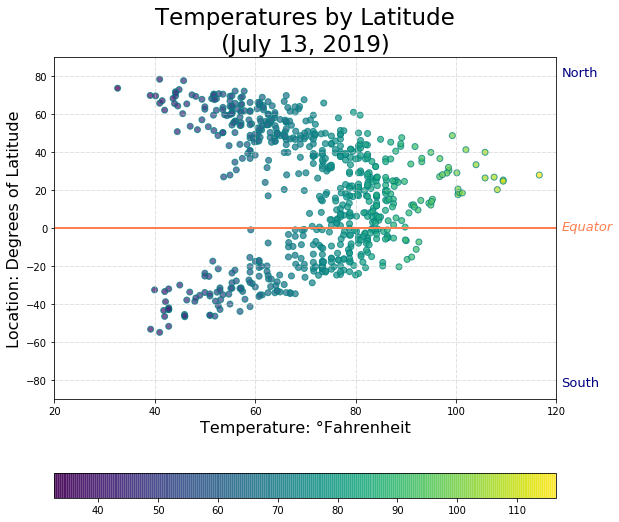

In [10]:
plt.figure(figsize = (9, 9))

plt.scatter(city_weather_df['Temperature (F)'], city_weather_df['Latitude'], 
            marker = 'o', 
            c = city_weather_df['Temperature (F)'],
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Temperatures by Latitude\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.ylabel('Location: Degrees of Latitude', fontsize = 16)
plt.ylim (-90, 90)

# Label and limits for y-axis.
plt.xlabel('Temperature: °Fahrenheit', fontsize = 16)
plt.xlim (20, 120)

# Add light grid with axis line for equator and notations for North and South
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axhline(linewidth = 2, color = 'coral')
plt.text (121, -1.25, 'Equator', fontsize = 13, color = 'coral', style = 'italic')
plt.text (121, 80, 'North', fontsize = 13, color = 'navy')
plt.text (121, -83, 'South', fontsize = 13, color = 'navy')

# Show colorbar
plt.colorbar(orientation = 'horizontal')
plt.savefig((f'ADDL - Temperature by Latitude {called_on}.png'))

plt.show()

### Humidity Plot (version 2)

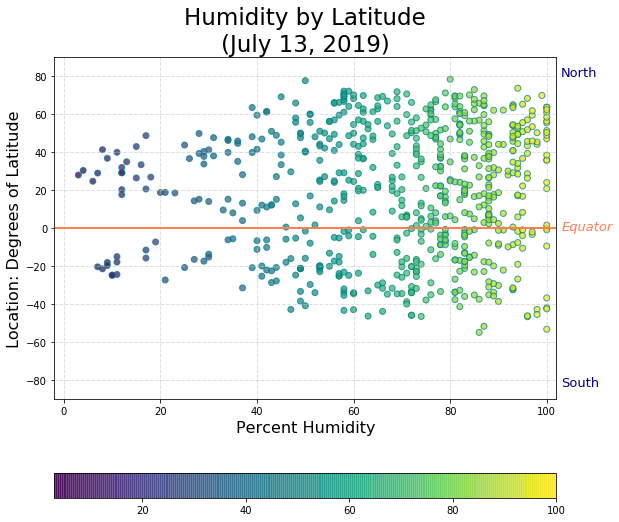

In [11]:
plt.figure(figsize = (9, 9))

plt.scatter(city_weather_df['Humidity (%)'], city_weather_df['Latitude'], 
            marker = 'o', 
            c = city_weather_df['Humidity (%)'],
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Humidity by Latitude\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.ylabel('Location: Degrees of Latitude', fontsize = 16)
plt.ylim (-90, 90)

# Label and limits for y-axis.
plt.xlabel('Percent Humidity', fontsize = 16)
plt.xlim (-2, 102)

# Add light grid with axis line for equator and notations for North and South
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axhline(linewidth = 2, color = 'coral')
plt.text (103, -1.25, 'Equator', fontsize = 13, color = 'coral', style = 'italic')
plt.text (103, 80, 'North', fontsize = 13, color = 'navy')
plt.text (103, -83, 'South', fontsize = 13, color = 'navy')

# Show colorbar
plt.colorbar(orientation = 'horizontal')
plt.savefig((f'ADDL - Humidity by Latitude {called_on}.png'))

plt.show()

### Cloudiness Plot  (version 2)

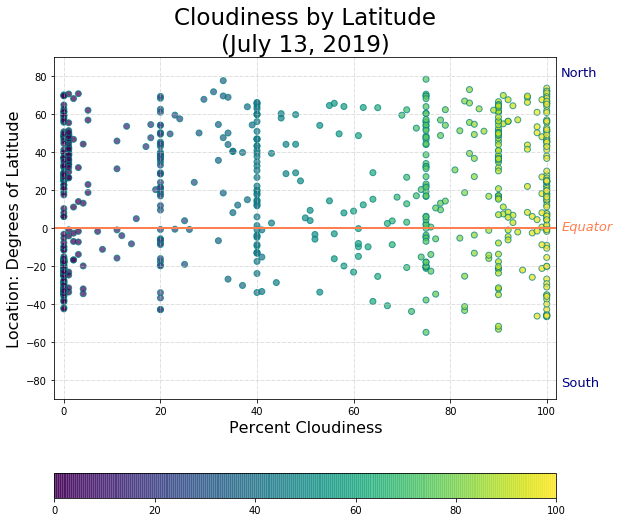

In [12]:
plt.figure(figsize = (9, 9))

plt.scatter(city_weather_df['Cloudiness (%)'], city_weather_df['Latitude'], 
            marker = 'o', 
            c = city_weather_df['Cloudiness (%)'],
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Cloudiness by Latitude\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.ylabel('Location: Degrees of Latitude', fontsize = 16)
plt.ylim (-90, 90)

# Label and limits for y-axis.
plt.xlabel('Percent Cloudiness', fontsize = 16)
plt.xlim (-2, 102)

# Add light grid with axis line for equator and notations for North and South
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axhline(linewidth = 2, color = 'coral')
plt.text (103, -1.25, 'Equator', fontsize = 13, color = 'coral', style = 'italic')
plt.text (103, 80, 'North', fontsize = 13, color = 'navy')
plt.text (103, -83, 'South', fontsize = 13, color = 'navy')

# Show colorbar
plt.colorbar(orientation = 'horizontal')
plt.savefig((f'ADDL - Cloudiness by Latitude {called_on}.png'))

plt.show()

### Wind Speed Plot  (version 2)

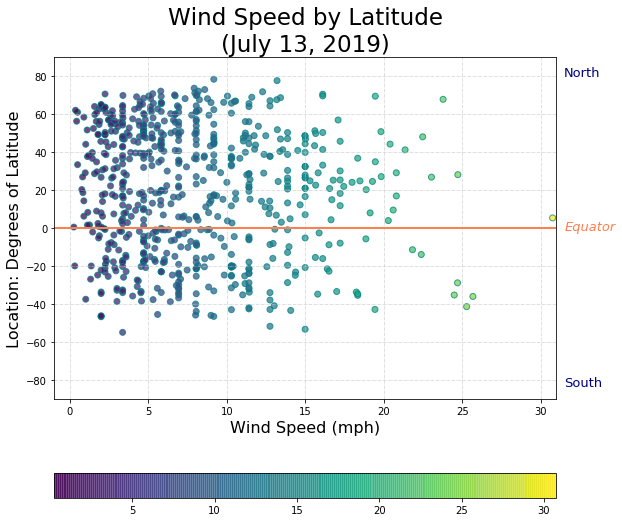

In [13]:
plt.figure(figsize = (9, 9))

plt.scatter(city_weather_df['Wind Speed (mph)'], city_weather_df['Latitude'], 
            marker = 'o', 
            c = city_weather_df['Wind Speed (mph)'],            
            edgecolor = 'teal', 
            alpha = 0.75)

# Title the plot.
plt.title((f'Wind Speed by Latitude\n({called_on})'), fontsize = 23)

# Label and limits for x-axis.
plt.ylabel('Location: Degrees of Latitude', fontsize = 16)
plt.ylim (-90, 90)

# Label and limits for y-axis.
plt.xlabel('Wind Speed (mph)', fontsize = 16)
plt.xlim (-1, 31)

# Add light grid with axis line for equator and notations for North and South
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axhline(linewidth = 2, color = 'coral')
plt.text (31.5, -1.25, 'Equator', fontsize = 13, color = 'coral', style = 'italic')
plt.text (31.5, 80, 'North', fontsize = 13, color = 'navy')
plt.text (31.5, -83, 'South', fontsize = 13, color = 'navy')

# Show colorbar
plt.colorbar(orientation = 'horizontal')
plt.savefig((f'ADDL - Wind Speed by Latitude {called_on}.png'))

plt.show()